In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [2]:
from scipy.stats.distributions import bernoulli
def throw_a_coin(n):
    brv = bernoulli(0.5)
    return brv.rvs(size=n)

In [3]:
random_flips = throw_a_coin(10000)
running_means = np.zeros(10000)
sequence_lengths = np.arange(1,10001,1)
for i in sequence_lengths:
    running_means[i-1] = np.mean(random_flips[:i])

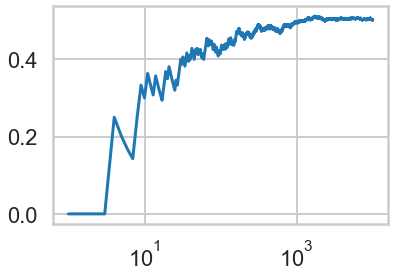

In [4]:
plt.plot(sequence_lengths, running_means);
plt.xscale('log')

In [5]:
def make_throws(number_of_samples, sample_size):
    start=np.zeros((number_of_samples, sample_size), dtype=int)
    for i in range(number_of_samples):
        start[i,:]=throw_a_coin(sample_size)
    return np.mean(start, axis=1)

In [6]:
make_throws(number_of_samples=20, sample_size=10)

array([0.7, 0.5, 0.8, 0.6, 0.5, 0.3, 0.5, 0.3, 0.5, 0.5, 0.7, 0.5, 0.5,
       0.6, 0.4, 0.5, 0.5, 0.5, 0.3, 0.5])

In [7]:
sample_sizes=np.arange(1,1001,1)
sample_means = [make_throws(number_of_samples=200, sample_size=i) for i in sample_sizes]

In [8]:
mean_of_sample_means = [np.mean(means) for means in sample_means]

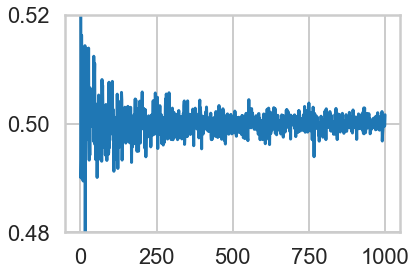

In [9]:
plt.plot(sample_sizes, mean_of_sample_means);
plt.ylim([0.480,0.520]);

In [10]:
sample_means_at_size_10=sample_means[9]
sample_means_at_size_100=sample_means[99]
sample_means_at_size_1000=sample_means[999]

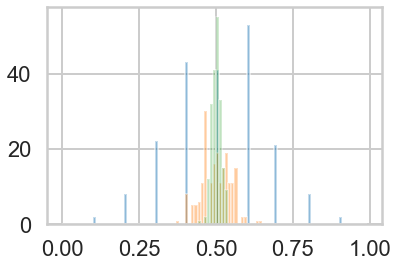

In [11]:
plt.hist(sample_means_at_size_10, bins=np.arange(0,1,0.01), alpha=0.5);
plt.hist(sample_means_at_size_100, bins=np.arange(0,1,0.01), alpha=0.4);
plt.hist(sample_means_at_size_1000, bins=np.arange(0,1,0.01), alpha=0.3);

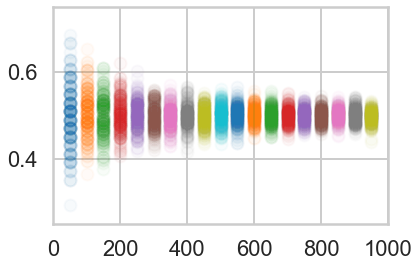

In [12]:
for i in sample_sizes:
    if i %50 ==0 and i < 1000:
        plt.scatter([i]*200, sample_means[i], alpha=0.03);
plt.xlim([0,1000])
plt.ylim([0.25,0.75]);

In [13]:
sample_sizes=np.arange(1,1001,1)
sample_means_1000_replicates = [make_throws(number_of_samples=1000, sample_size=i) for i in sample_sizes]

In [14]:
std_of_sample_means_1000 = [np.std(means) for means in sample_means_1000_replicates]

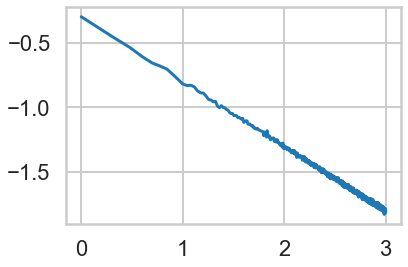

In [15]:
plt.plot(np.log10(sample_sizes), np.log10(std_of_sample_means_1000));

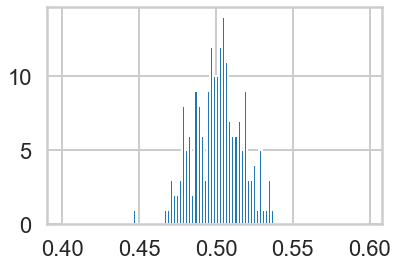

In [16]:
plt.hist(sample_means_at_size_1000, bins=np.arange(0.4,0.6,0.002));

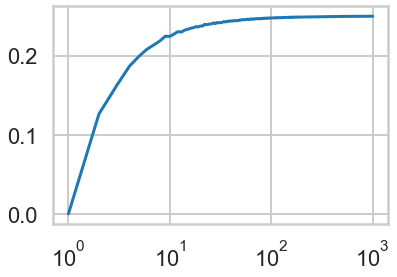

In [17]:
def make_throws_var(number_of_samples, sample_size):
    start=np.zeros((number_of_samples, sample_size), dtype=int)
    for i in range(number_of_samples):
        start[i,:]=throw_a_coin(sample_size)
    return np.var(start, axis=1)
sample_vars_1000_replicates = [make_throws_var(number_of_samples=1000, sample_size=i) for i in sample_sizes]
mean_of_sample_vars_1000 = [np.mean(vars) for vars in sample_vars_1000_replicates]
plt.plot(sample_sizes, mean_of_sample_vars_1000);
plt.xscale("log");

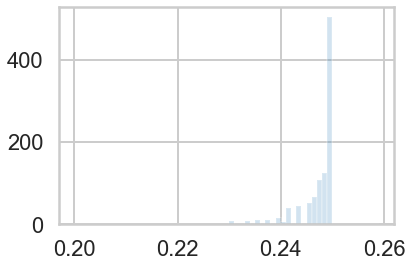

In [18]:
plt.hist(sample_vars_1000_replicates[99], bins=np.arange(0.2,0.26,0.001), alpha=0.2, density=True);

In [19]:
gallup_2012=pd.read_csv("g12.csv").set_index('State')
gallup_2012["Unknown"] = 100 - gallup_2012.Democrat - gallup_2012.Republican
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown
State,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4
Alaska,35.9,44.3,-8.4,402,19.8
Arizona,39.8,47.3,-7.5,4325,12.9
Arkansas,41.5,40.8,0.7,2071,17.7
California,48.3,34.6,13.7,16197,17.1


In [20]:
gallup_2012["SE_percentage"]=100.0*np.sqrt((gallup_2012.Democrat/100.)*((100. - gallup_2012.Democrat)/100.)/(gallup_2012.N -1))
gallup_2012.head()

,Democrat,Republican,Dem_Adv,N,Unknown,SE_percentage
State,,,,,,
Alabama,36.0,49.6,-13.6,3197,14.4,0.849059
Alaska,35.9,44.3,-8.4,402,19.8,2.395543
Arizona,39.8,47.3,-7.5,4325,12.9,0.744384
Arkansas,41.5,40.8,0.7,2071,17.7,1.082971
California,48.3,34.6,13.7,16197,17.1,0.392658


In [21]:
predictwise = pd.read_csv("predictwise.csv").set_index('States')
predictwise.head()

,Obama,Romney,Votes
States,,,
Alabama,0.000,1.000,9
Alaska,0.000,1.000,3
Arizona,0.062,0.938,11
Arkansas,0.000,1.000,6
California,1.000,0.000,55


In [22]:
def simulate_election(model, n_sim):
    simulations = np.random.uniform(size=(51, n_sim))
    obama_votes = (simulations < model.Obama.values.reshape(-1, 1)) * model.Votes.values.reshape(-1, 1)
    return obama_votes.sum(axis=0)

In [23]:
def plot_simulation(simulation):    
    plt.hist(simulation, bins=np.arange(200, 538, 1), label='simulations', align='left', density=True)
    plt.axvline(332, 0, .5, color='r', label='Actual Outcome')
    plt.axvline(269, 0, .5, color='k', label='Victory Threshold')
    p05 = np.percentile(simulation, 5.)
    p95 = np.percentile(simulation, 95.)
    iq = int(p95 - p05)
    pwin = ((simulation >= 269).mean() * 100)
    plt.title("Chance of Obama Victory: %0.2f%%, Spread: %d votes" % (pwin, iq))
    plt.legend(frameon=False, loc='upper left')
    plt.xlabel("Obama Electoral College Votes")
    plt.ylabel("Probability")
    sns.despine()

In [24]:
from scipy.special import erf
def uncertain_gallup_model(gallup):
    sigma = 3
    prob =  .5 * (1 + erf(gallup.Dem_Adv / np.sqrt(2 * sigma**2)))
    return pd.DataFrame(dict(Obama=prob), index=gallup.index)

In [25]:
model = uncertain_gallup_model(gallup_2012)
model = model.join(predictwise.Votes)

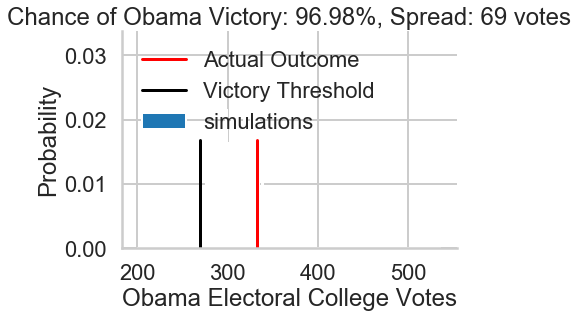

In [26]:
prediction = simulate_election(model, 10000)
plot_simulation(prediction)